### Imports & Load Data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Load Data
df = pd.read_parquet("../data/EURUSD_D1.parquet")
print(f"Loaded {len(df)} daily candles.")
# transferred for accuracy

Loaded 1552 daily candles.


### Calculate Volatility (ATR) 

✅ Loaded 1539 rows.
✅ ATR calculated manually.


,open,high,low,close,tick_volume,spread,real_volume,atr
time,,,,,,,,
2025-12-18,1.17378,1.17629,1.17122,1.17240,59197,8,0,0.005326
2025-12-19,1.17169,1.17377,1.17027,1.17090,48493,8,0,0.005125
2025-12-22,1.17158,1.17382,1.17061,1.17315,19208,8,0,0.005106


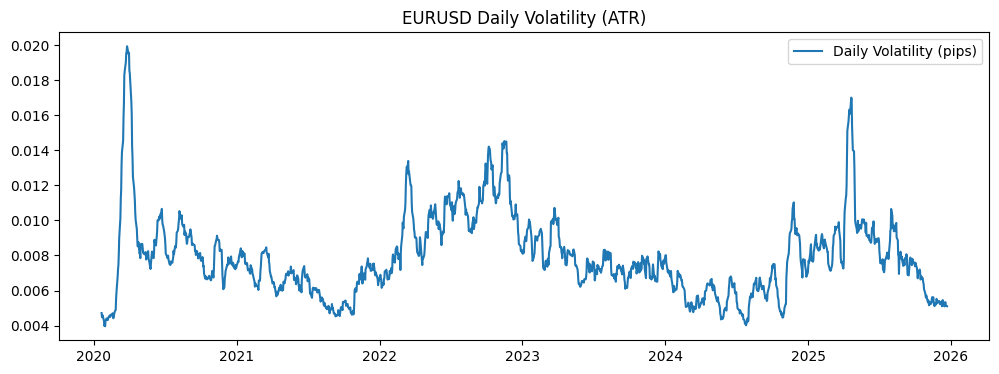

In [55]:
 # --- MANUAL INDICATOR FUNCTIONS (No Dependencies) ---


def calculate_atr(df, period=14):
    """
    Calculates Average True Range (ATR) manually.
    TR = Max(High-Low, Abs(High-PrevClose), Abs(Low-PrevClose))
    ATR = Rolling Mean of TR
    """
    # Calculate the 3 components of True Range
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    
    # Combine them into a temporary DataFrame and take the Max per row
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    
    # Calculate ATR (Simple Rolling Mean is standard for ML)
    atr = true_range.rolling(window=period).mean()
    return atr

# load the data
# df = pd.read_parquet("../data/EURUSD_D1.parquet")

# 2. Apply Calculations
df['atr'] = calculate_atr(df, period=14)

# Drop NaN values (first 200 rows will be empty due to SMA/ATR warm-up)
df.dropna(inplace=True)

print(f"✅ Loaded {len(df)} rows.")
print("✅ ATR calculated manually.")
display(df.tail(3))

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['atr'], label="Daily Volatility (pips)")
plt.title("EURUSD Daily Volatility (ATR)")
plt.legend()
plt.show()

# some times the market moves much at times it doesnt we need dynamic stops

### save the df with atr and sma

In [56]:
# df.to_parquet('../data/EURUSD_D1_with_atr.parquet')

### START HERE!!!!

### __The Triple Barrier Logic (The Core)_ this signals one false trade before the big reversal

In [57]:
# loading the df
import pandas as pd

# df = pd.read_parquet('../data/EURUSD_D1_with_atr.parquet')

# this is where the trading strategy gets defined
# takes the dataframe with our data
# looks ahead 2 days, the atr multiplie is used to set the barriers
def apply_symmetric_barrier(df, look_ahead_days, atr_multiplier):
    """
    Symmetric Triple Barrier Method
    -------------------------------
    1  (Bull) = Hit Upper Barrier ONLY
    -1 (Bear) = Hit Lower Barrier ONLY
    0  (Range)= Hit NEITHER or Hit BOTH (Noise)
    """
    # this is the answer list
    labels = []
    
    # Iterate through every day (except the last few where there are no days to look ahead to)
    for i in range(len(df) - look_ahead_days):
        # grabs the current row
        current_row = df.iloc[i]
        
        # this is the hypothetical entry price we assume we enter the trade when the day closes
        entry_price = current_row['close']
        
        # this is the current volatility that is based on the past 14 days worth of market motion
        # if atr is 100, then a big move is 100 pips
        current_atr = current_row['atr']
        
        # 1. Define Symmetric Barriers
        # We use the same distance for Bull and Bear to be fair
        barrier_distance = current_atr * atr_multiplier

        # calculate the actual prices for bullish and bearish moves
        upper_barrier = entry_price + barrier_distance
        lower_barrier = entry_price - barrier_distance
        
        # 2. Look Ahead Window
        # this storews the future days to so we can check if the price hit the upper or lower barriers or none
        future_window = df.iloc[i+1 : i+look_ahead_days+1]
        
        # 3. Check touches
        hit_upper = (future_window['high'] >= upper_barrier).any()
        hit_lower = (future_window['low'] <= lower_barrier).any()
        
       # 4. Assign Symmetric Labels
        if hit_upper and not hit_lower:
            labels.append(1)   # Clean Bull Move
            
        elif hit_lower and not hit_upper:
            labels.append(-1)  # Clean Bear Move
            
        elif hit_upper and hit_lower:
            labels.append(0)   # Volatility/Whipsaw -> Treat as NO TRADE
            
        else:
            labels.append(0)   # Range -> Treat as NO TRADE
            
    # Fill the remaining rows with NaN (since we can't look forward for them)
    labels.extend([np.nan] * look_ahead_days)
    
    return labels

# Apply it
print("Applying Symmetric Labels...")
# the atr multiplier regulates how much the market has to be moving for the supervisor to warrant a trade
df['label'] = apply_symmetric_barrier(df, look_ahead_days=2, atr_multiplier=0.8)

# Drop NaNs
df.dropna(inplace=True)

# Check New Balance
print("\nNew Class Balance:")
print(df['label'].value_counts(normalize=True).sort_index())

Applying Symmetric Labels...

New Class Balance:
label
-1.0    0.320104
 0.0    0.322707
 1.0    0.357189
Name: proportion, dtype: float64


### Visualize the "Truth"

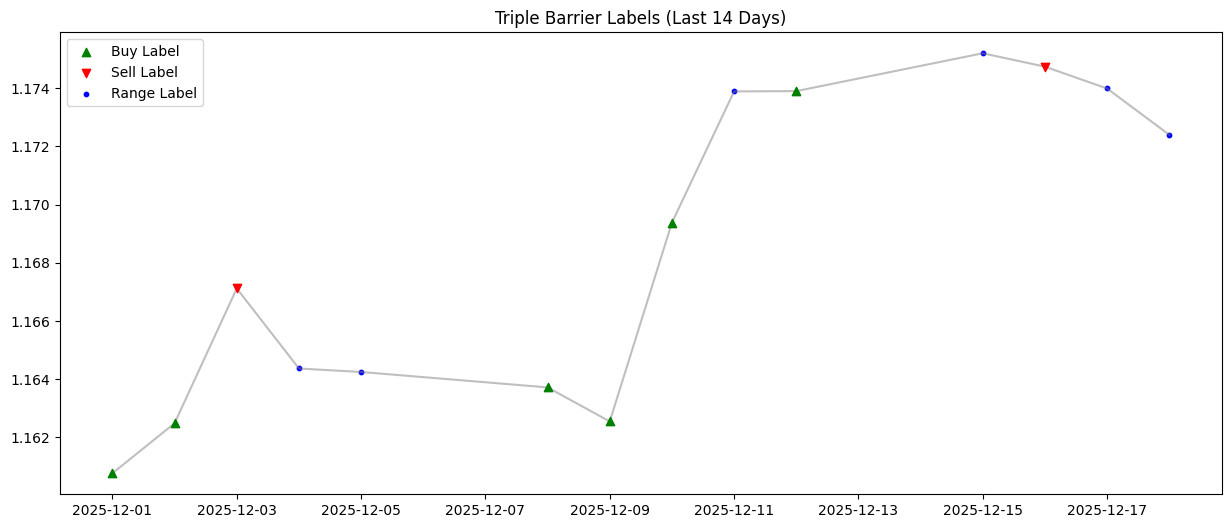

In [58]:
# Plot last 100 days
days_to_plot = 14
# grab a subset of the df
subset = df.tail(days_to_plot)

plt.figure(figsize=(15, 6))
plt.plot(subset.index, subset['close'], alpha=0.5, color='gray')

# Plot Buys (Green dots)
buys = subset[subset['label'] == 1]
plt.scatter(buys.index, buys['close'], color='green', marker='^', label='Buy Label', zorder=5)

# Plot Sells (Red dots)
sells = subset[subset['label'] == -1]
plt.scatter(sells.index, sells['close'], color='red', marker='v', label='Sell Label', zorder=5)

# Plot Range (Blue dots - tiny)
ranges = subset[subset['label'] == 0]
plt.scatter(ranges.index, ranges['close'], color='blue', s=10, label='Range Label')

plt.title(f"Triple Barrier Labels (Last {days_to_plot} Days)")
plt.legend()
plt.show()

In [60]:
print(len(df))

1537


### Save

In [61]:
# Save the Labeled Supervisor Data
df.to_parquet("../data/EURUSD_D1_Labeled.parquet")
print("✅ Saved labeled data.")

✅ Saved labeled data.


In [62]:
df.columns

Index(['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume',
       'atr', 'label'],
      dtype='object')

In [63]:
len(df)

1537